In [2]:
!pip install pycaret
!pip install imbalanced-learn
!pip install optuna lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import random
import lightgbm as lgb
import requests
import sys
import optuna
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.feature_selection import RFE
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope
from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, predict_model
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
# connect to personal google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# define function to download file from google drive
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7'
destination = 'term-deposit-marketing-2020.csv'
download_file_from_google_drive(file_id, destination)
df=pd.read_csv(destination)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# Data Analysis

In [7]:
# check for missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [8]:
# check data types
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [9]:
print(df.describe())
print(df.describe(include=['object']))

                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000
                job  marital  education default housing   loan   contact  \
count         40000    40000      40000   40000   40000  40000     40000   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
fre

In [23]:
# split df between subsribed and unsubscribed

df_y1 = df[df['y'] == 'yes']
print('subscribed:')
print(df_y1.describe())
df_y0 = df[df['y'] == 'no']
print('not subscribed:')
print(df_y0.describe())

subscribed:
               age       balance          day     duration     campaign
count  2896.000000   2896.000000  2896.000000  2896.000000  2896.000000
mean     39.844959   1588.495856    15.827003   682.958564     2.414365
std      11.001984   2924.894429     8.557604   431.287174     2.306015
min      19.000000  -3058.000000     1.000000     8.000000     1.000000
25%      31.000000    141.000000     8.000000   364.000000     1.000000
50%      37.000000    620.000000    16.000000   629.000000     2.000000
75%      47.000000   1820.500000    22.000000   913.000000     3.000000
max      95.000000  45248.000000    31.000000  3881.000000    32.000000
not subscribed:
                age        balance           day      duration      campaign
count  37104.000000   37104.000000  37104.000000  37104.000000  37104.000000
mean      40.599208    1249.752533     16.032072    221.408042      2.918688
std        9.525450    2900.722436      8.255850    206.360022      3.298031
min       19.000

In [24]:

print('subscribed:')
print(df_y1.describe(include=object))
print('not subscribed:')
print(df_y0.describe(include=object))

subscribed:
               job  marital  education default housing  loan   contact month  \
count         2896     2896       2896    2896    2896  2896      2896  2896   
unique          12        3          4       2       2     2         3    11   
top     management  married  secondary      no     yes    no  cellular   may   
freq           676     1478       1418    2847    1464  2516      2233   791   

           y  
count   2896  
unique     1  
top      yes  
freq    2896  
not subscribed:
                job  marital  education default housing   loan   contact  \
count         37104    37104      37104   37104   37104  37104     37104   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           8848    22908      19575   36344   22567  30554     22681   

        month      y  
count   37104  37104  
unique     11      1  
top       may     no  
freq    12741  37104  


In [25]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [26]:
for column in df.columns:
    unique_values = df[column].value_counts()
    print(f"Value counts in column '{column}':")
    print(unique_values)
    print("\n")

Value counts in column 'age':
age
32    1909
31    1826
33    1770
34    1730
35    1721
      ... 
90       1
94       1
86       1
95       1
81       1
Name: count, Length: 70, dtype: int64


Value counts in column 'job':
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64


Value counts in column 'marital':
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64


Value counts in column 'education':
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64


Value counts in column 'default':
default
no     39191
yes      809
Name: count, dtype: int64


Value counts in column 'balance':
balance
 0         3209
 1          179
 2          141
 4          126
 3 

# Phase 1:  Determine customers that are more like to buy the investment product.

## Data Wrangling

In [27]:
# replace yes, no with 1 and 0
df.replace(['no', 'yes'], [0,1], inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [28]:
# create a month number column
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Apply the mapping to the 'month' column
df['month_number'] = df['month'].map(month_map)
# Remove month column
df.drop('month', axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,y,month_number
0,58,management,married,tertiary,0,2143,1,0,unknown,5,261,1,0,5
1,44,technician,single,secondary,0,29,1,0,unknown,5,151,1,0,5
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,0,5
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,0,5
4,33,unknown,single,unknown,0,1,0,0,unknown,5,198,1,0,5


In [29]:
#split data between target 'Y' and variables 'X'
X = df.drop('y',axis=1)
Y = df['y']
print(Y)
print(X.head())

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64
   age           job  marital  education  default  balance  housing  loan  \
0   58    management  married   tertiary        0     2143        1     0   
1   44    technician   single  secondary        0       29        1     0   
2   33  entrepreneur  married  secondary        0        2        1     1   
3   47   blue-collar  married    unknown        0     1506        1     0   
4   33       unknown   single    unknown        0        1        0     0   

   contact  day  duration  campaign  month_number  
0  unknown    5       261         1             5  
1  unknown    5       151         1             5  
2  unknown    5        76         1             5  
3  unknown    5        92         1             5  
4  unknown    5       198         1             5  


In [30]:
# Split data out customer related data
X_customer_cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']
X_customer = X[X_customer_cols]
X_customer.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


## Data Visualization

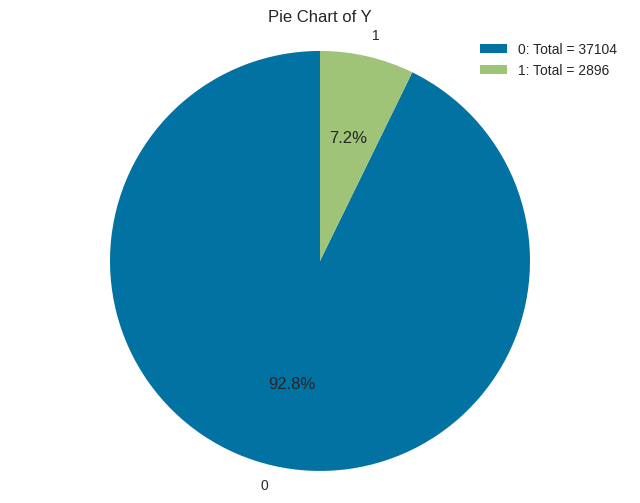

In [31]:
# Replace this with your actual data and labels
y_counts = df['y'].value_counts()
labels = y_counts.index
sizes = y_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


#### Pie chart shows highly imbalance data with ~ 93% unsubsribed



### Subscription status by categorical features

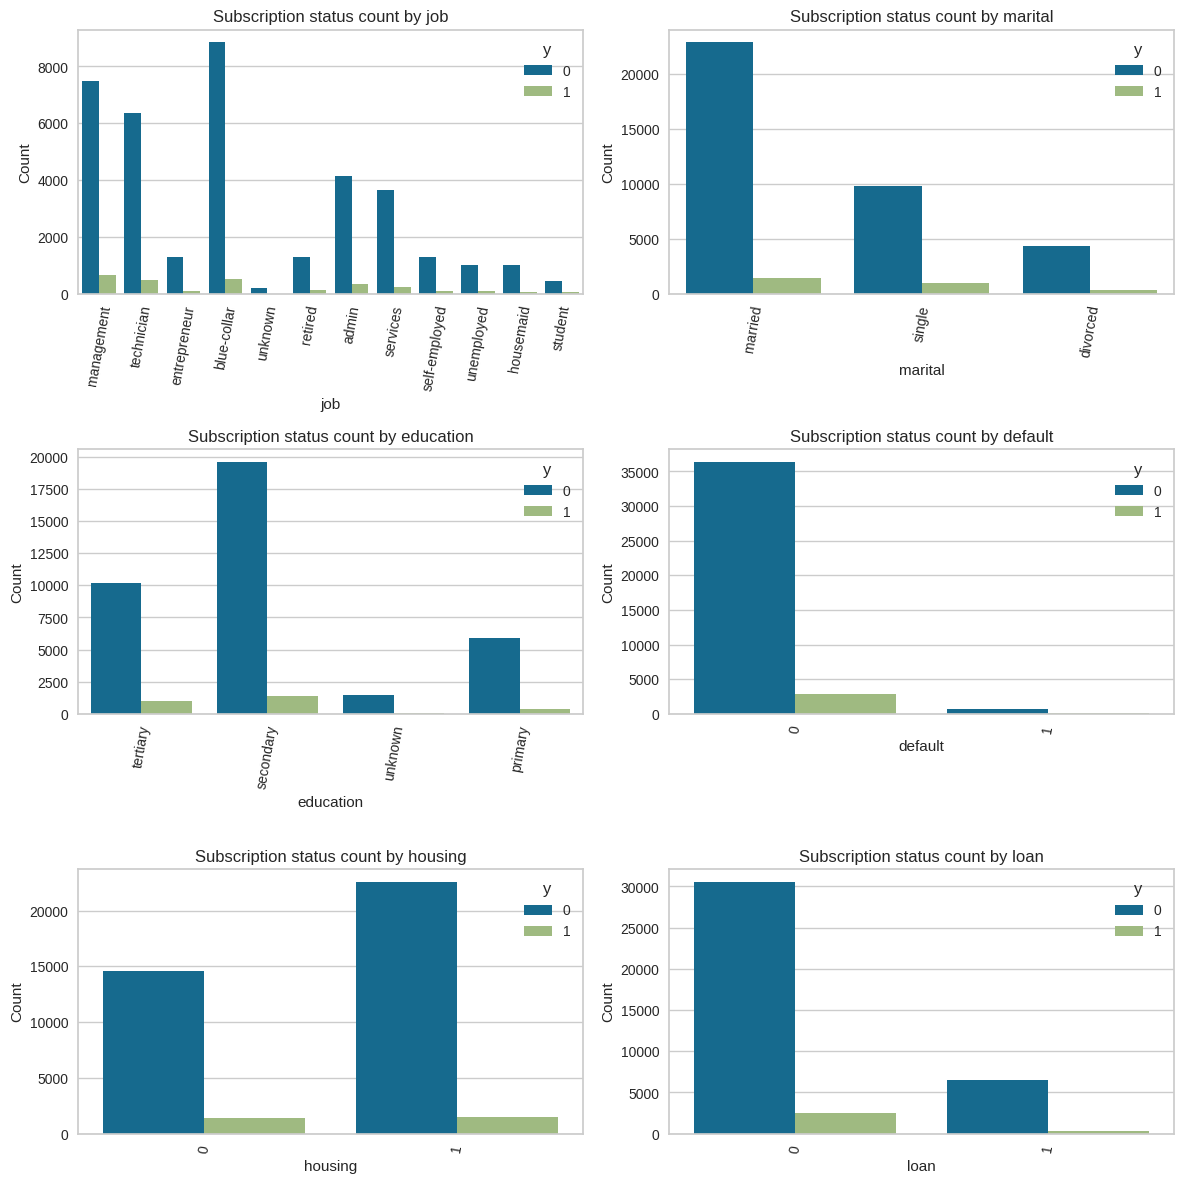

In [39]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['job', 'marital', 'education', 'default', 'housing', 'loan']):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Subscription status count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Subscription status by continous features

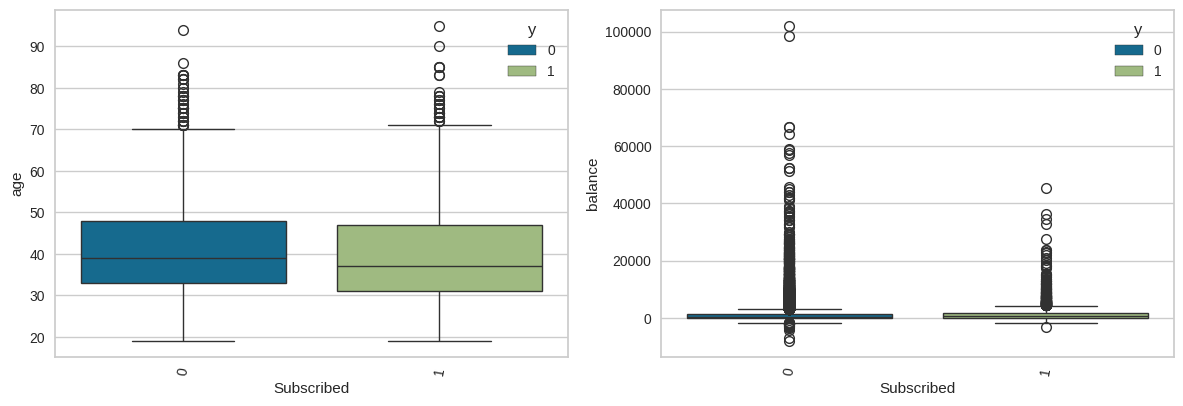

In [40]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['age', 'balance']):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=col, x='y', data=df, hue='y')
    plt.xlabel('Subscribed')
    plt.ylabel(col)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## Data rebalancing

In [41]:
# convert categorical columns with one hot encoding
X_customer = pd.get_dummies(data=X_customer, columns=(['job', 'marital', 'education']), drop_first=True)

# scaling of continous features
continous_cols = ['age', 'balance']
transform = preprocessing.StandardScaler()
X_customer[continous_cols] = transform.fit_transform(X_customer[continous_cols])
# convert binary values to float type
X_customer = X_customer.astype(float)
X_customer.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,1.810415,0.0,0.299174,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.358382,0.0,-0.428854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.782501,0.0,-0.438152,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.669532,0.0,0.079802,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.782501,0.0,-0.438497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [42]:
# convert target values to float type

Y = Y.astype(float)
Y.head()

,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [43]:
seed = random.randint(1000,9999)
print(seed)

5114


In [44]:
# Splitting training and testing sets before rebalancing to preserve
X_train, X_test, y_train, y_test = train_test_split(X_customer,Y, test_size=0.2, random_state=seed)
print(f'X_train shape:',X_train.shape)
print(f'y_train shape:',y_train.shape)
print(f'X_test shape:',X_test.shape)
print(f'y_test shape:',y_test.shape)

X_train shape: (32000, 21)
y_train shape: (32000,)
X_test shape: (8000, 21)
y_test shape: (8000,)


In [45]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.93      1.00      0.96      7426
    Subscribed       0.00      0.00      0.00       574

      accuracy                           0.93      8000
     macro avg       0.46      0.50      0.48      8000
  weighted avg       0.86      0.93      0.89      8000



In [46]:
et =  ExtraTreesClassifier(random_state=seed)
et.fit(X_train, y_train)
y_pred = et.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.93      0.96      0.94      7426
    Subscribed       0.15      0.10      0.12       574

      accuracy                           0.90      8000
     macro avg       0.54      0.53      0.53      8000
  weighted avg       0.88      0.90      0.89      8000



In [47]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.93      0.99      0.96      7426
    Subscribed       0.20      0.02      0.04       574

      accuracy                           0.92      8000
     macro avg       0.57      0.51      0.50      8000
  weighted avg       0.88      0.92      0.89      8000



### Method 1:  Random Undersampler

In [48]:
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f'X_train resample:',X_rus.shape)
print(f'y_train resample:',y_rus.shape)

X_train resample: (4644, 21)
y_train resample: (4644,)


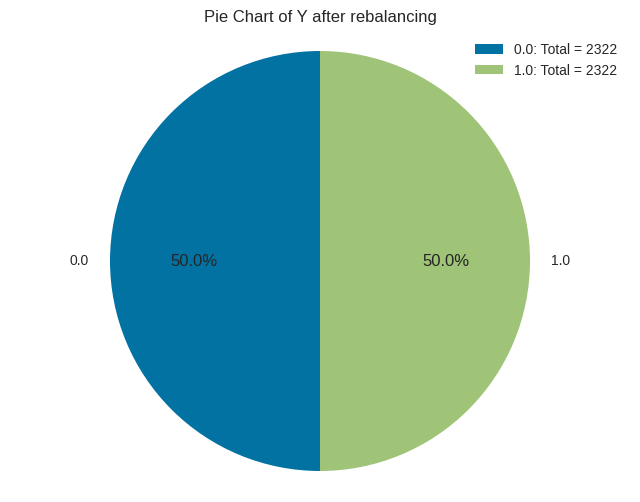

In [49]:
# Replace this with your actual data and labels
y_rus_counts = y_rus.value_counts()
labels = y_rus_counts.index
sizes = y_rus_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with RUS



In [50]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_rus, pd.DataFrame(y_rus, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,5114
1,Target,y
2,Target type,Binary
3,Original data shape,"(4644, 22)"
4,Transformed data shape,"(4644, 22)"
5,Transformed train set shape,"(3250, 22)"
6,Transformed test set shape,"(1394, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5652,0.5996,0.5212,0.5718,0.5450,0.1305,0.1311,0.1860
gbc,Gradient Boosting Classifier,0.5643,0.5926,0.5311,0.5693,0.5486,0.1286,0.1293,0.3420
lr,Logistic Regression,0.5631,0.5913,0.5631,0.5636,0.5629,0.1262,0.1264,1.7340
ridge,Ridge Classifier,0.5622,0.5910,0.5606,0.5630,0.5613,0.1243,0.1245,0.0440
lda,Linear Discriminant Analysis,0.5615,0.5909,0.5618,0.5622,0.5615,0.1231,0.1233,0.0620
nb,Naive Bayes,0.5600,0.5849,0.6388,0.5524,0.5913,0.1200,0.1221,0.0380
rf,Random Forest Classifier,0.5578,0.5714,0.5520,0.5584,0.5550,0.1157,0.1158,0.4780
qda,Quadratic Discriminant Analysis,0.5532,0.5735,0.6671,0.5447,0.5983,0.1065,0.1095,0.0380
knn,K Neighbors Classifier,0.5474,0.5576,0.5440,0.5478,0.5458,0.0948,0.0948,0.0880
svm,SVM - Linear Kernel,0.5474,0.5858,0.5883,0.5521,0.5569,0.0948,0.1007,0.0600


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.6228,0.5946,0.4965,0.0946,0.1589,0.0436,0.0687


In [51]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_rus, y_rus)
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.60      0.73      7426
    Subscribed       0.09      0.54      0.16       574

      accuracy                           0.59      8000
     macro avg       0.52      0.57      0.44      8000
  weighted avg       0.88      0.59      0.69      8000



In [53]:
et =  ExtraTreesClassifier(random_state=seed)
et.fit(X_rus, y_rus)
y_pred = et.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.57      0.71      7426
    Subscribed       0.08      0.52      0.15       574

      accuracy                           0.56      8000
     macro avg       0.51      0.54      0.43      8000
  weighted avg       0.88      0.56      0.67      8000



In [54]:
knn = KNeighborsClassifier()
knn.fit(X_rus, y_rus)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.57      0.71      7426
    Subscribed       0.09      0.54      0.15       574

      accuracy                           0.57      8000
     macro avg       0.51      0.55      0.43      8000
  weighted avg       0.88      0.57      0.67      8000



### Method 2:  SMOTE-ENN

In [55]:
sme = SMOTEENN(random_state=seed)
X_sme, y_sme = sme.fit_resample(X_train, y_train)
print(f'X_train resample:',X_sme.shape)
print(f'y_train resample:',y_sme.shape)

X_train resample: (38750, 21)
y_train resample: (38750,)


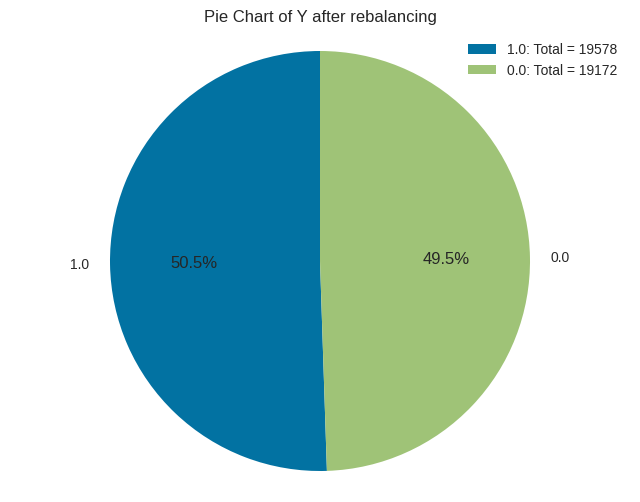

In [56]:
# Replace this with your actual data and labels
y_sme_counts = y_sme.value_counts()
labels = y_sme_counts.index
sizes = y_sme_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with SMOTE-ENN

In [57]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_sme, pd.DataFrame(y_sme, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,5114
1,Target,y
2,Target type,Binary
3,Original data shape,"(38750, 22)"
4,Transformed data shape,"(38750, 22)"
5,Transformed train set shape,"(27125, 22)"
6,Transformed test set shape,"(11625, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9766,0.9961,0.9769,0.9767,0.9768,0.9531,0.9531,2.6560
rf,Random Forest Classifier,0.9585,0.9909,0.9537,0.9639,0.9587,0.9171,0.9171,2.9380
lightgbm,Light Gradient Boosting Machine,0.9225,0.9714,0.8744,0.9692,0.9193,0.8451,0.8493,1.4240
xgboost,Extreme Gradient Boosting,0.9121,0.9689,0.8763,0.9459,0.9098,0.8244,0.8267,0.8420
dt,Decision Tree Classifier,0.9105,0.9104,0.9156,0.9081,0.9118,0.8209,0.8211,0.1820
knn,K Neighbors Classifier,0.9071,0.9700,0.9394,0.8839,0.9108,0.8140,0.8156,1.9000
gbc,Gradient Boosting Classifier,0.7909,0.8779,0.7775,0.8026,0.7898,0.5820,0.5823,2.7280
ada,Ada Boost Classifier,0.6978,0.7742,0.7053,0.6992,0.7022,0.3954,0.3955,0.8300
ridge,Ridge Classifier,0.6262,0.6758,0.6272,0.6309,0.6290,0.2525,0.2525,0.0780
lda,Linear Discriminant Analysis,0.6260,0.6758,0.6269,0.6307,0.6287,0.2519,0.2519,0.1620


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7676,0.5837,0.2962,0.1046,0.1546,0.0543,0.0643


In [58]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_sme, y_sme)
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.58      0.72      7426
    Subscribed       0.09      0.55      0.16       574

      accuracy                           0.58      8000
     macro avg       0.52      0.57      0.44      8000
  weighted avg       0.88      0.58      0.68      8000



In [59]:
et =  ExtraTreesClassifier(random_state=seed)
et.fit(X_sme, y_sme)
y_pred = et.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.80      0.87      7426
    Subscribed       0.11      0.30      0.16       574

      accuracy                           0.77      8000
     macro avg       0.52      0.55      0.51      8000
  weighted avg       0.88      0.77      0.81      8000



In [60]:
knn = KNeighborsClassifier()
knn.fit(X_sme, y_sme)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.71      0.81      7426
    Subscribed       0.09      0.38      0.15       574

      accuracy                           0.69      8000
     macro avg       0.51      0.54      0.48      8000
  weighted avg       0.88      0.69      0.76      8000



### Method 3:  SMOTE-Tomek

In [61]:
smt = SMOTETomek(random_state=seed)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
print(f'X_train resample:',X_smt.shape)
print(f'y_train resample:',y_smt.shape)

X_train resample: (55724, 21)
y_train resample: (55724,)


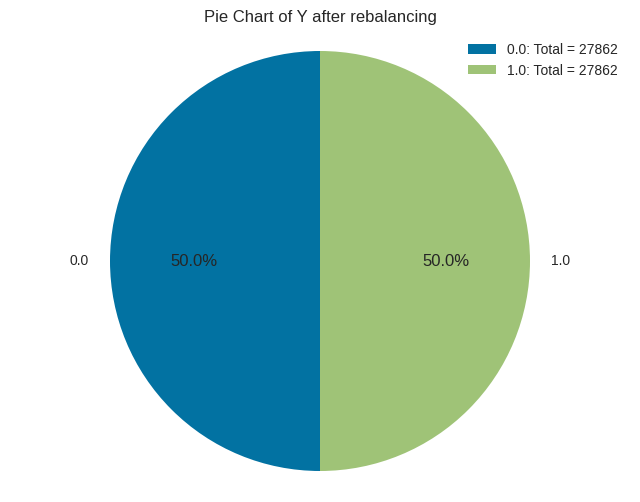

In [62]:
# Replace this with your actual data and labels
y_smt_counts = y_smt.value_counts()
labels = y_smt_counts.index
sizes = y_smt_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y after rebalancing')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Model Comparison after rebalacing with SMOTE-Tomek

In [63]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_smt, pd.DataFrame(y_smt, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models()

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));

,Description,Value
0,Session id,5114
1,Target,y
2,Target type,Binary
3,Original data shape,"(55724, 22)"
4,Transformed data shape,"(55724, 22)"
5,Transformed train set shape,"(39006, 22)"
6,Transformed test set shape,"(16718, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9022,0.9500,0.8208,0.9804,0.8935,0.8044,0.8153,1.5460
et,Extra Trees Classifier,0.8976,0.9559,0.8998,0.8959,0.8978,0.7953,0.7953,4.8600
rf,Random Forest Classifier,0.8872,0.9516,0.8836,0.8901,0.8868,0.7745,0.7745,4.8180
dt,Decision Tree Classifier,0.8807,0.8813,0.8841,0.8781,0.8811,0.7614,0.7614,0.4340
xgboost,Extreme Gradient Boosting,0.8755,0.9395,0.8001,0.9421,0.8653,0.7509,0.7596,0.8040
knn,K Neighbors Classifier,0.7996,0.8790,0.8712,0.7621,0.8130,0.5992,0.6055,3.3540
gbc,Gradient Boosting Classifier,0.7856,0.8633,0.7419,0.8130,0.7758,0.5713,0.5735,3.9220
ada,Ada Boost Classifier,0.6607,0.7294,0.6703,0.6576,0.6638,0.3213,0.3215,1.1180
lda,Linear Discriminant Analysis,0.5950,0.6296,0.5962,0.5947,0.5954,0.1899,0.1900,0.2100
ridge,Ridge Classifier,0.5948,0.6296,0.5960,0.5946,0.5953,0.1896,0.1896,0.0920


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9168,0.6163,0.0540,0.2013,0.0852,0.0565,0.0703


In [64]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_smt, y_smt)
y_pred = lr.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.59      0.73      7426
    Subscribed       0.09      0.54      0.16       574

      accuracy                           0.59      8000
     macro avg       0.52      0.57      0.44      8000
  weighted avg       0.88      0.59      0.69      8000



In [65]:
et =  ExtraTreesClassifier(random_state=seed)
et.fit(X_smt, y_smt)
y_pred = et.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.93      0.88      0.91      7426
    Subscribed       0.10      0.17      0.13       574

      accuracy                           0.83      8000
     macro avg       0.52      0.53      0.52      8000
  weighted avg       0.87      0.83      0.85      8000



In [66]:
knn = KNeighborsClassifier()
knn.fit(X_smt, y_smt)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
print(report)

                precision    recall  f1-score   support

Not Subscribed       0.94      0.76      0.84      7426
    Subscribed       0.09      0.32      0.15       574

      accuracy                           0.73      8000
     macro avg       0.52      0.54      0.49      8000
  weighted avg       0.88      0.73      0.79      8000



## Predictive Analysis

In [67]:
# define a confusion matrix plotter
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['not subsribed', 'subscribed']); ax.yaxis.set_ticklabels(['not subsribed', 'subscribed'])
    plt.show()

### LightGBM model

In [68]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        pass# Suppress warnings by not doing anything pass

    def error(self, message):
        self.logger.error(message)
# Register the custom logger
lgb.register_logger(CustomLogger())

In [69]:
# optimize lgbm using optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(stopping_rounds=10)])
    preds = model.predict(X_test)

    #accuracy = accuracy_score(y_test, preds)
    #return accuracy
    f1 = f1_score(y_test, preds, average='macro')
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)

print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best trial value:', study.best_trial.value)


Number of finished trials: 100
Best trial parameters: {'max_depth': 18, 'num_leaves': 55, 'learning_rate': 0.017058668064927816, 'n_estimators': 132, 'min_child_samples': 6, 'subsample': 0.7388578855767044, 'colsample_bytree': 0.8965367258296838}
Best trial value: 0.5538977002002714


                precision    recall  f1-score   support

Not Subscribed       0.94      0.91      0.92      7426
    Subscribed       0.16      0.22      0.18       574

      accuracy                           0.86      8000
     macro avg       0.55      0.57      0.55      8000
  weighted avg       0.88      0.86      0.87      8000



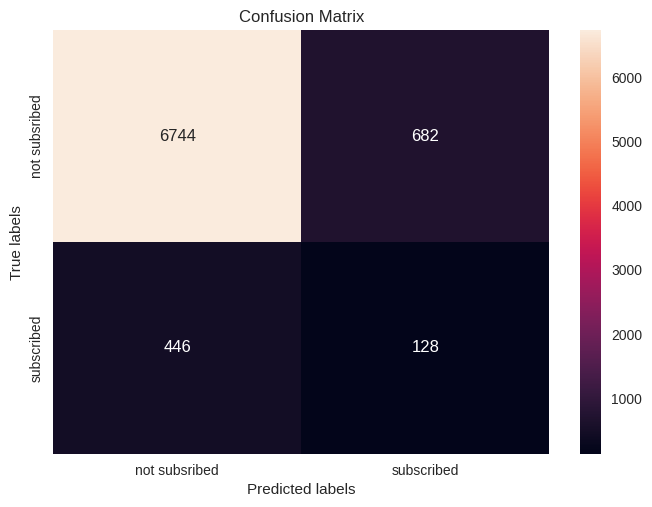

In [70]:
# Train a model with the best hyperparameters
best_params_lgbm = study.best_trial.params

# Convert parameters to integer if needed
#for parameter_name in ['max_depth', 'num_leaves', 'min_child_samples', 'n_estimators']:
#    best_lgbm[parameter_name] = int(best_lgbm[parameter_name])
lgbm_best = lgb.LGBMClassifier(**best_params_lgbm)

lgbm_best.fit(
    X_smt, y_smt,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)
y_pred = lgbm_best.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
report_lgbm = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'], output_dict=True)
precision_lgbm = report_lgbm['Subscribed']['precision']
print(report)
plot_confusion_matrix(y_test,y_pred)